# 多项式（线性）回归

### Q1：使用多项式模型拟合样本点 X,Y  (2')

绘制原样本点分布和拟合曲线 (1')，并计算拟合优度R方(1')   

关于R方，可参考: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

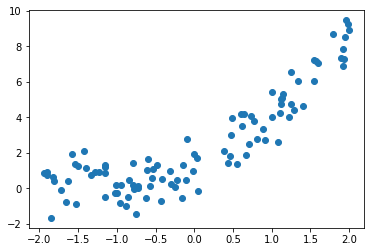

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
X = np.random.uniform(-2, 2, size=N).flatten()
Y = X**2 + 2*X + 1 + np.random.normal(0, 1, N).flatten()
Y = Y[np.argsort(X)]
X = np.sort(X).reshape(-1,1)
plt.scatter(X, Y)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [6]:
model=LinearRegression().fit(X,Y)

In [7]:
yfit=model.predict(X)

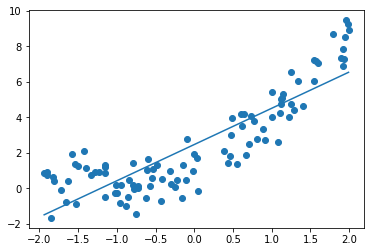

In [8]:
plt.scatter(X,Y)
plt.plot(X,yfit)

In [13]:
r2_score(Y,yfit)

0.7455951068752309

In [10]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=2,include_bias=False)
X2=poly.fit_transform(X)
print(X2[:10])

[[-1.93746356  3.75376504]
 [-1.89790078  3.60202738]
 [-1.89717823  3.59928522]
 [-1.85002579  3.42259541]
 [-1.82895245  3.34506706]
 [-1.80632722  3.26281803]
 [-1.71748218  2.94974502]
 [-1.6593549   2.75345867]
 [-1.63520194  2.67388538]
 [-1.57608556  2.48404569]]


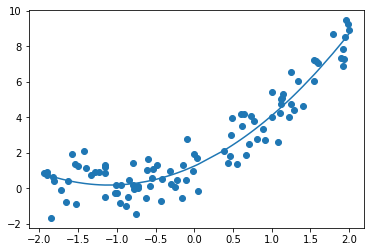

In [11]:
model=LinearRegression().fit(X2,Y)
yfit2=model.predict(X2)
plt.scatter(X,Y)
plt.plot(X,yfit2)

In [14]:
r2_score(Y,yfit2)

0.897136670386805

# ARMA 模型

使用的数据为Google的股票开盘数据

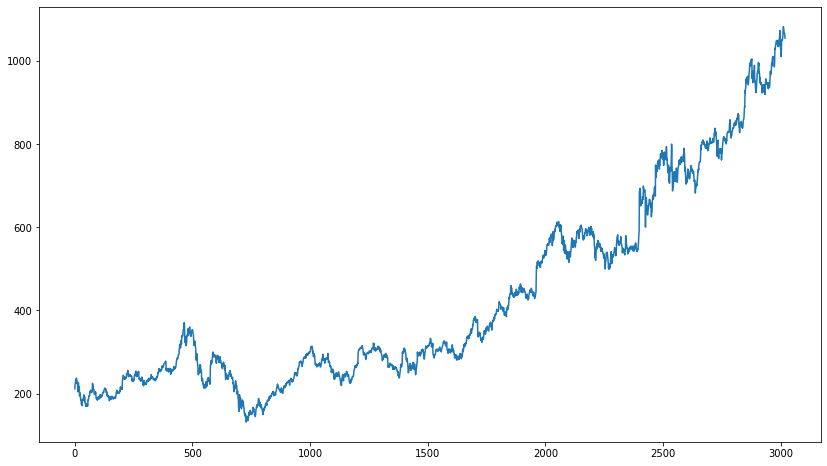

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt

df = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv')
data = np.array(df.Open)

plt.figure(figsize=(14, 8)) 
plt.plot(data)
plt.show()

### Q2：通过差分等变换手段将序列变成平稳序列 (2')

检验平稳性的函数为 adfuller， 其输出结果为 一个tuple，


这里判断是否平稳时，可以用输出结果的值与后面 1%， 5% 和 10% 的值做大小比较，实际中一般要求 5% 的置信度就可以了，也就是 计算结果的adf 要小于 5% 对应的值时，认为序列是平稳的，这部分的内容是数理统计部分的假设检验，有兴趣的可以再多了解



In [2]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print(result)

(1.240364410251055, 0.9962532356713726, 27, 2991, {'1%': -3.4325382049645357, '5%': -2.8625068071065787, '10%': -2.5672846570213257}, 20185.84146337278)


将data变为平稳序列 dataY，并做adf检验， 要求置信度要求在 5%（统计量小于 5%对应的统计量）

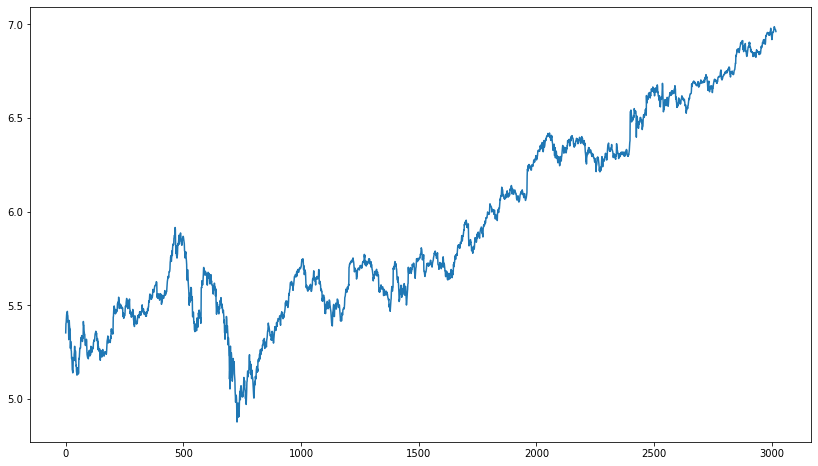

In [26]:
# dataY=np.diff(np.log(data))
dataY=np.log(data)
plt.figure(figsize=(14, 8)) 
plt.plot(dataY)
plt.show()

In [4]:
print(adfuller(dataY))

(-12.317314578947526, 6.875113150667955e-23, 18, 2999, {'1%': -3.43253236279788, '5%': -2.86250422682754, '10%': -2.5672832833096195}, -15467.038506886463)


### Q3：利用ARMA进行建模 (4')


利用 ARMA 模型进行平稳序列的预测，计算对应的 MSE 误差

如果采用 AIC 或者 BIC 选择阶数，可以使用 statsmodels.tsa.stattools 里面的 arma_order_select_ic 函数来选取，用法如下

order = statsmodels.tsa.stattools.arma_order_select_ic(X, max_ar=10, max_ma=10, ic=\['aic', 'bic'])

其中 max_ar 和 max_ma 表示最大选取的AR模型的阶数以及 MA 模型的阶数

ARMA 模型的使用方式大致如下

1. fit 模型 model = ARMA(data, order=(AR_p, MA_q)).fit() AR_p代表 AR部分的阶数， MA_q 代表 MA 部分的阶数
2. 预测模型 可以获得 对应模型的参数 coef =  model.params 其中前 AR_p + 1个表示 AR模型部分的参数， 后面 MA_q 个参数为 MA 模型的参数，也可以直接使用 ARMA 模型中的 predict 函数：pred = model.predict(start=start_index, end=end_index)

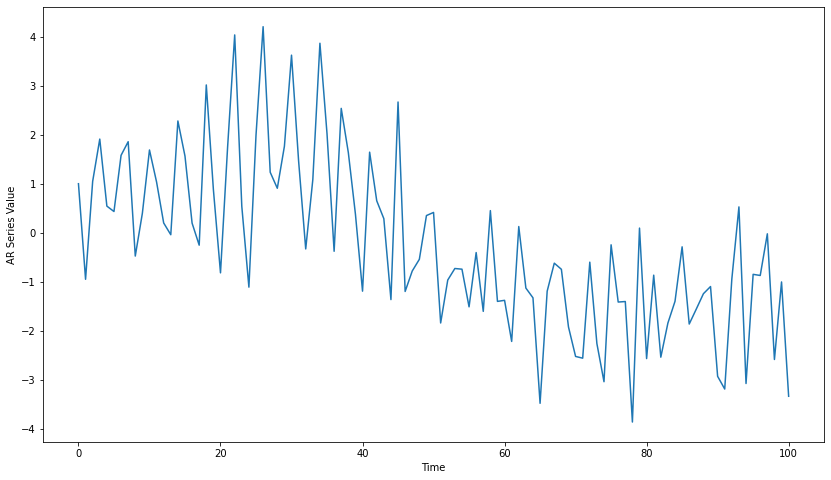

In [5]:
# 示例
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
# ensures experiment runs the same every time
np.random.seed(100)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]

    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05, 0.02])
X = np.array([1])

mu = 0
sigma = 1

for i in range(100):
    X = np.append(X, AR(b, X, mu, sigma))

plt.figure(figsize=(14, 8))
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR Series Value')
plt.show()

### 选择阶数示例

In [8]:
import warnings
warnings.filterwarnings("ignore")

order = tsa.stattools.arma_order_select_ic(X, max_ar=3, max_ma=3, ic=['aic', 'bic'])
print(order.aic_min_order)
print(order.bic_min_order)

(3, 3)
(3, 3)


### fit ARMA 模型示例

coefs:[-0.36754064  0.86059697  0.12353735 -0.81869983]


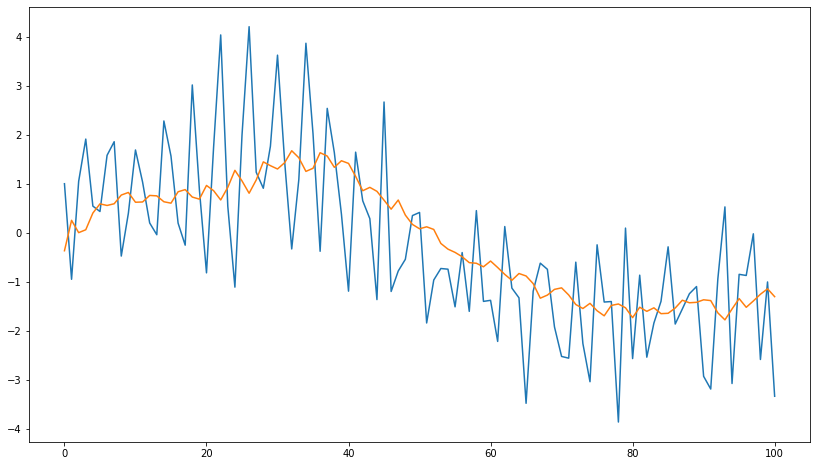

In [8]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(X, order=(2, 1)).fit()
pred = model.predict(start = 0, end = 100)

#通过获取回归系数计算
#获取回归方程的系数
coefs = model.params
print(f"coefs:{coefs}")

# 此处为 AR 3 阶模型， MA 1 阶模型
# 获得的参数为 AR模型中的 phi0 phi1 phi2，以及 MA模型中的 theta1
plt.figure(figsize=(14, 8))  
plt.plot(X)
plt.plot(pred)

plt.show()

使用 ARMA 模型对data进行建模
 1. 前面已经对数据做了平稳性的变换，现在对这个平稳序列进行ARMA建模，利用AIC和BIC估计阶数 (2')
 2. 对平稳性数据建模之后需要恢复成对原始数据的建模(例如 做过log变换, 恢复时就使用指数变换) (1')
 3. 绘制建模恢复的数据与原始数据的曲线图 (1')

In [33]:
order = tsa.stattools.arma_order_select_ic(dataY, max_ar=5, max_ma=5, ic=['aic', 'bic'])
print(order.aic_min_order)
print(order.bic_min_order)

(2, 1)
(1, 0)


coefs:[6.0752799  0.06509324 0.9342204  0.91272442]


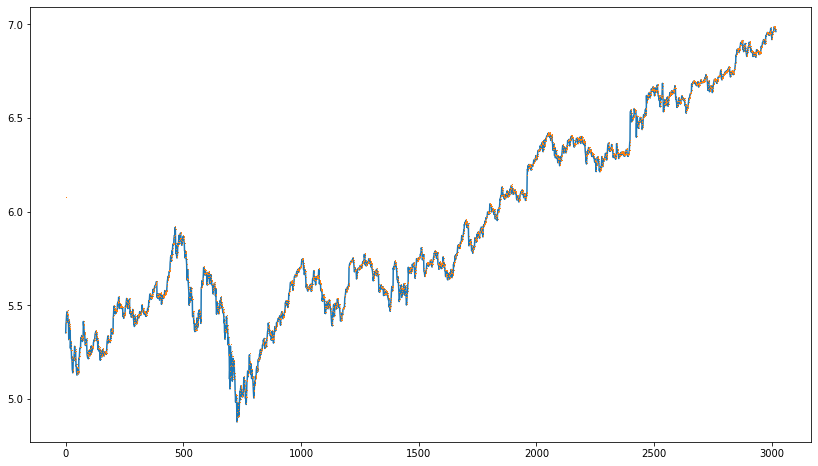

In [13]:
model = ARMA(dataY, order=(2, 1)).fit()
pred = model.predict(start = 0, end = dataY.shape[0]-1)

coefs = model.params
print(f"coefs:{coefs}")
plt.figure(figsize=(14, 8))  
plt.plot(dataY)
plt.plot(pred,',')

plt.show()

In [14]:
pred_exp=np.exp(pred)

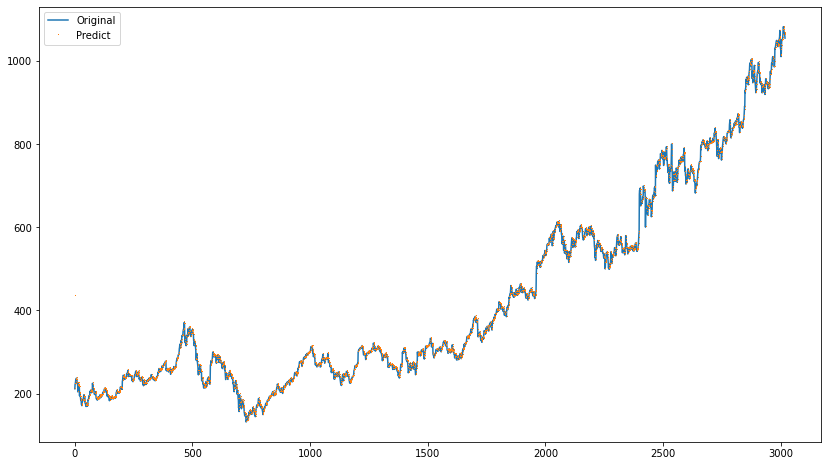

In [15]:
plt.figure(figsize=(14, 8)) 
plt.plot(data)
plt.plot(pred_exp,',')
plt.legend(['Original','Predict'])
plt.show()

### Q4：指数滑动平均 (Exponential Moving Average, EMA)   (2')

与均值滑动平均(Equally Weighted Moving Average) 不同，窗口内的各权值按指数递减，距离越远，权值越小。  

EAM的计算公式为：
$EMA_t = \alpha y_t + (1-\alpha)EMA_{t-1}$  

其中，$\alpha \in (0,1)$表示权重的衰减程度，$\alpha$ 越大，当前抽样值的权重越高，滑动平均的实时性越强，相反，$\alpha$ 越小，平稳性更高。$\alpha$ 实际上控制权重计算中有效项的个数，即指数平滑有效窗口的大小。

可以参考：https://zhuanlan.zhihu.com/p/151786842  

https://www.coursera.org/lecture/deep-neural-network/exponentially-weighted-averages-duStO

In [16]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
N = 100
X = np.random.randint(10, 15, size=N)
X_index = np.arange(N)

# alpha分别取值0.9和0.1，绘制经过指数滑窗滤波后的数据曲线和原数据曲线
# TODO: 


In [72]:
def EMA(y,alpha):
    ema=np.zeros(y.shape[0]+1)
    ema[0]=0
    for i in range(1,y.shape[0]+1):
        ema[i]=alpha*y[i-1]+(1-alpha)*ema[i-1]
    return ema[1:]

In [73]:
X_ema_9=EMA(X,0.9)
X_ema_1=EMA(X,0.1)

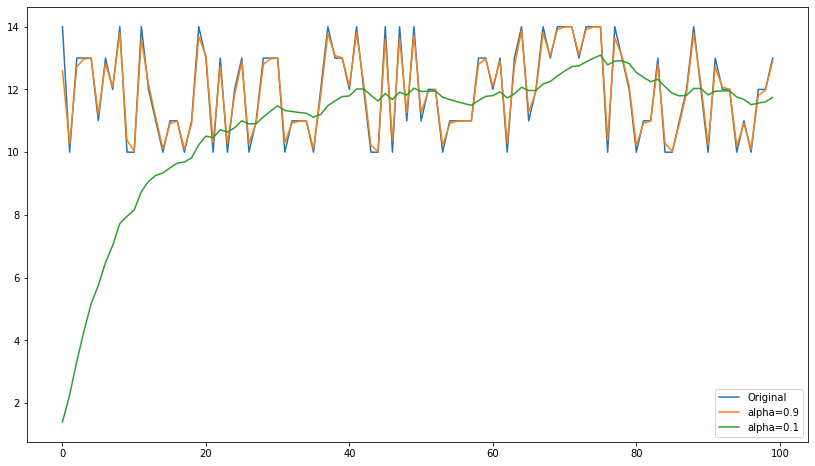

In [74]:
plt.figure(figsize=(14, 8)) 
plt.plot(X)
plt.plot(X_ema_9)
plt.plot(X_ema_1)
plt.legend(['Original','alpha=0.9','alpha=0.1'])
plt.show()

可以看到，当 $\alpha$ 的值较小时，开始阶段的平滑后数据接近于0，和原数据可能有较大的偏差。因此引入偏差修正公式：
$$EMA_t = \frac{EMA_t}{1-(1-\alpha)^t}$$

偏差修正后，重新计算$\alpha=0.1$ 时的滤波后数据，并绘制曲线图。

In [77]:
# TODO:
X_ema_1_revise=X_ema_1/(1-np.power(0.9,X_index+1))

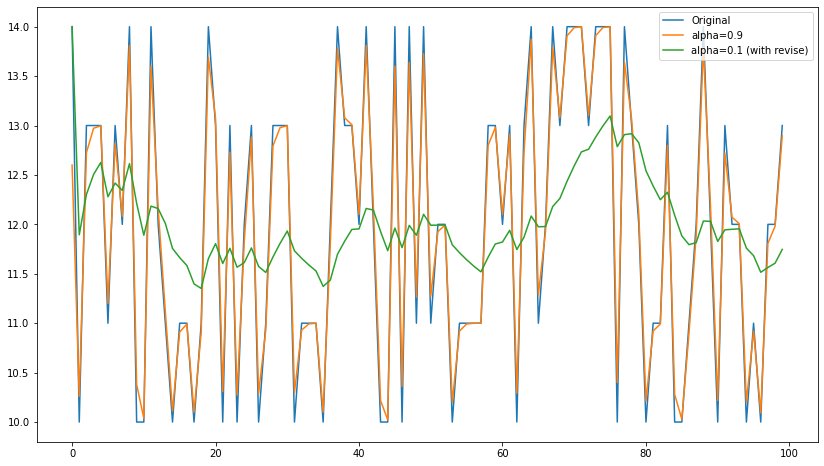

In [78]:
plt.figure(figsize=(14, 8)) 
plt.plot(X)
plt.plot(X_ema_9)
plt.plot(X_ema_1_revise)
plt.legend(['Original','alpha=0.9','alpha=0.1 (with revise)'])
plt.show()